In [8]:
import glob
import os
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

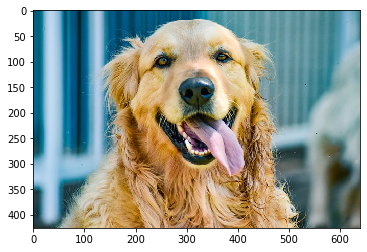

In [4]:
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

plt.imshow(img)
plt.show();

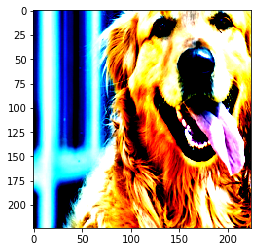

In [5]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase='train')

img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)

plt.imshow(img_transformed)
plt.show();

In [6]:
def make_datapath_list(phase='train'):
    rootpath = './data/hymenoptera_data/'
    target_path = os.path.join(rootpath + phase + '/**/*.jpg')
    print(target_path)
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
    
    return path_list

In [7]:
train_list = make_datapath_list(phase='train')
val_list = make_datapath_list(phase='val')

train_list

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train\\ants\\0013035.jpg',
 './data/hymenoptera_data/train\\ants\\1030023514_aad5c608f9.jpg',
 './data/hymenoptera_data/train\\ants\\1095476100_3906d8afde.jpg',
 './data/hymenoptera_data/train\\ants\\1099452230_d1949d3250.jpg',
 './data/hymenoptera_data/train\\ants\\116570827_e9c126745d.jpg',
 './data/hymenoptera_data/train\\ants\\1225872729_6f0856588f.jpg',
 './data/hymenoptera_data/train\\ants\\1262877379_64fcada201.jpg',
 './data/hymenoptera_data/train\\ants\\1269756697_0bce92cdab.jpg',
 './data/hymenoptera_data/train\\ants\\1286984635_5119e80de1.jpg',
 './data/hymenoptera_data/train\\ants\\132478121_2a430adea2.jpg',
 './data/hymenoptera_data/train\\ants\\1360291657_dc248c5eea.jpg',
 './data/hymenoptera_data/train\\ants\\1368913450_e146e2fb6d.jpg',
 './data/hymenoptera_data/train\\ants\\1473187633_63ccaacea6.jpg',
 './data/hymenoptera_data/train\\ants\\148715752_302c84f5a4.jpg',
 './data/hymenoptera_data/train\\ants\\1489674356_09d48dde0a.jpg',
 './data/hym

In [9]:
class HymenopteraDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        
        if self.phase == 'train':
            label = img_path[30:34]
        elif self.phase == 'val':
            label = img_path[28:32]
        
        if label == 'ants':
            label = 0
        elif label == 'bees':
            label = 1
        
        return img_transformed, label

In [10]:
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

In [11]:
index = 0

print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [12]:
batch_size = 32

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {
    'train': train_dataloader,
    'val': val_dataloader
}

In [13]:
batch_iterator = iter(dataloaders_dict['train'])

inputs, labels = next(batch_iterator)

print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 1])


In [14]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

net.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [15]:
criterion = nn.CrossEntropyLoss()

In [16]:
params_to_update = []

update_param_names = ['classifier.6.weight', 'classifier.6.bias']

for name, param in net.named_parameters():
    if name in update_param_names:
        param.required_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.required_grad = False

print(params_to_update)

classifier.6.weight
classifier.6.bias
[Parameter containing:
tensor([[ 0.0117,  0.0116,  0.0082,  ..., -0.0072,  0.0059, -0.0065],
        [-0.0071, -0.0131, -0.0117,  ..., -0.0079, -0.0070,  0.0085]],
       requires_grad=True), Parameter containing:
tensor([-0.0087,  0.0008], requires_grad=True)]


In [17]:
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [18]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('----------')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0
            
            if (epoch == 0) and (phase == 'train'):
                continue
            
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

In [19]:
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/2
----------


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.8070 Acc: 0.3595
Epoch 2/2
----------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.5038 Acc: 0.7160


100%|██████████| 5/5 [01:13<00:00, 14.72s/it]

val Loss: 0.1812 Acc: 0.9412
